In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using Plots, DifferentialEquations, StaticArrays, LaTeXStrings

In [3]:
x0 = 0.1
etat0 = @SVector [x0]

1-element SVector{1, Float64} with indices SOneTo(1):
 0.1

In [4]:
n = 3.0     # natalité
m = 2.0     # morrtalité
par_malthus = [n, m] # packing

2-element Vector{Float64}:
 3.0
 2.0

In [5]:
tspan = (0.0, 5.0)
tstep = 0.1

0.1

In [6]:
function malthus(u, p, t)
    n, m = p        # unpacking
    x = u[1]        # use x notation
    dx = (n-m)x     # no need for multiplication 
    @SVector [dx]   # return derivative as SVector
end

malthus (generic function with 1 method)

In [7]:
prob_malthus = ODEProblem(malthus,          # modèle
                          etat0,            # condition initiale
                          tspan,            # tspan
                          par_malthus,      # paramètres
                          saveat = tstep)   # option de sortie

ODEProblem with uType SVector{1, Float64} and tType Float64. In-place: false
timespan: (0.0, 5.0)
u0: 1-element SVector{1, Float64} with indices SOneTo(1):
 0.1

In [8]:
sol_malthus = solve(prob_malthus)

retcode: Success
Interpolation: 1st order linear
t: 51-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 ⋮
 3.9
 4.0
 4.1
 4.2
 4.3
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0
u: 51-element Vector{SVector{1, Float64}}:
 [0.1]
 [0.1105170918098962]
 [0.12214028021690636]
 [0.13498587256890127]
 [0.1491824967995758]
 [0.16487211887837677]
 [0.1822118088926235]
 [0.2013752759904508]
 [0.2225541873299437]
 [0.2459601086193487]
 [0.27182789212481995]
 [0.3004165681038553]
 [0.3320119892325201]
 ⋮
 [4.939998877318704]
 [5.459546563772299]
 [6.033819931565917]
 [6.668489858108825]
 [7.36986008589588]
 [8.144932560593231]
 [9.001372810408137]
 [9.947822344252208]
 [10.993901057806614]
 [12.15020723352194]
 [13.428317540618487]
 [14.840787035086022]

In [9]:
#| output: true
first(sol_malthus.t, 3)

3-element Vector{Float64}:
 0.0
 0.1
 0.2

In [10]:
#| output: true
first(sol_malthus.u, 3)

3-element Vector{SVector{1, Float64}}:
 [0.1]
 [0.1105170918098962]
 [0.12214028021690636]

In [11]:
using DataFrames

sol_malthus = DataFrame(sol_malthus)
rename!(sol_malthus, :timestamp => :time, :value1 => :x)

Row,time,x
,Float64,Float64
1,0.0,0.1
2,0.1,0.110517
3,0.2,0.12214
4,0.3,0.134986
5,0.4,0.149182
6,0.5,0.164872
7,0.6,0.182212
8,0.7,0.201375
9,0.8,0.222554


In [12]:
#| output: true
first(sol_malthus, 3)

Row,time,x
,Float64,Float64
1,0.0,0.1
2,0.1,0.110517
3,0.2,0.12214


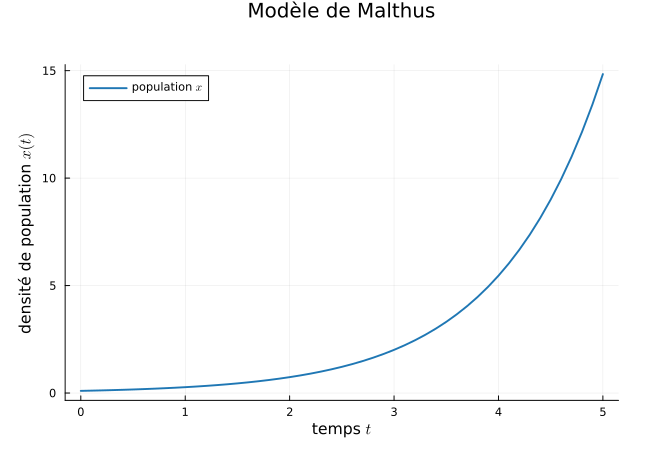

In [13]:
#| output: true
plot(sol_malthus.time, sol_malthus.x,
    palette = :tab10,
    linewidth = 2,
    title = "Modèle de Malthus",
    label = "population " * L"x",  # latex strings, makrdown latex is off in labels
    ylabel = "densité de population \$x(t)\$", # latex markdown is ok in axis label
    xlabel = "temps \$t\$",
    margin = .5Plots.cm,
    topmargin = 1Plots.cm)